In [1]:
# Install Required Libraries
!pip install ultralytics gradio matplotlib pillow numpy

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
from ultralytics import YOLO, RTDETR, YOLOWorld
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import io
import gradio as gr
import numpy as np

# Full-Image Detection Function
def detect_full_image(image, model, confidence_threshold=0.25):
    result = model.predict(image, conf=confidence_threshold)[0]
    detections = []
    for box in result.boxes:
        xmin, ymin, xmax, ymax = box.xyxy[0].tolist()
        class_id = int(box.cls[0].item())
        class_name = model.names[class_id]
        confidence = box.conf[0].item()
        area = (xmax - xmin) * (ymax - ymin)
        detections.append({
            "box": [xmin, ymin, xmax, ymax],
            "class_id": class_id,
            "class_name": class_name,
            "confidence": confidence,
            "area": area
        })
    return detections


In [3]:
# Guided Object Inference Slicing Function
def guided_object_inference_slicing(image, model, CoarseToFine_Slcing=256, confidence_threshold=0.25):
    original_image = image.copy()
    image_width, image_height = original_image.size
    detections = []

    step = int(CoarseToFine_Slcing * 0.8)  # 20% overlap
    for y in range(0, image_height, step):
        for x in range(0, image_width, step):
            box = (x, y, min(x + CoarseToFine_Slcing, image_width), min(y + CoarseToFine_Slcing, image_height))
            slice_img = original_image.crop(box)
            result = model.predict(slice_img, conf=confidence_threshold)[0]
            for detected_box in result.boxes:
                xmin, ymin, xmax, ymax = detected_box.xyxy[0].tolist()
                xmin += x
                xmax += x
                ymin += y
                ymax += y
                class_id = int(detected_box.cls[0].item())
                class_name = model.names[class_id]
                confidence = detected_box.conf[0].item()
                area = (xmax - xmin) * (ymax - ymin)
                detections.append({
                    "box": [xmin, ymin, xmax, ymax],
                    "class_id": class_id,
                    "class_name": class_name,
                    "confidence": confidence,
                    "area": area
                })
    return detections



In [4]:
# Draw Detections on Image
def draw_detections(image, detections):
    draw = ImageDraw.Draw(image)
    try:
        font = ImageFont.truetype("arial.ttf", 24)
    except IOError:
        font = ImageFont.load_default()

    for detection in detections:
        xmin, ymin, xmax, ymax = detection["box"]
        class_name = detection["class_name"]
        confidence = detection["confidence"]

        # Draw bounding box
        draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=2)

        # Draw label
        label = f"{class_name} {confidence:.2f}"
        draw.text((xmin, ymin), label, fill="yellow", font=font)

    return image



In [5]:
# Generate Bar Chart
def generate_bar_chart(full_metrics, gois_metrics, labels):
    fig, ax = plt.subplots(figsize=(8, 5))
    bar_width = 0.35
    x = np.arange(len(labels))

    ax.bar(x - bar_width / 2, full_metrics, width=bar_width, label="Full Image")
    ax.bar(x + bar_width / 2, gois_metrics, width=bar_width, label="GOIS-Sliced Image")

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    plt.title("Detection Results Comparison")
    plt.tight_layout()

    return fig_to_pil(fig)

# Generate Pie Chart
def generate_pie_chart(class_counts, title):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.pie(class_counts.values(), labels=class_counts.keys(), autopct='%1.1f%%', startangle=90)
    plt.title(title)
    plt.tight_layout()

    return fig_to_pil(fig)

# Generate HTML Table for Class Distribution
def generate_class_table(class_counts, title):
    table = f"""
    <h3 style="text-align:center; color:#007acc;">{title}</h3>
    <table style="width:100%; border-collapse: collapse;">
        <thead style="background-color:#007acc; color:white;">
            <tr>
                <th style="padding:8px; text-align:center;">Class Name</th>
                <th style="padding:8px; text-align:center;">Count</th>
            </tr>
        </thead>
        <tbody>
    """
    for class_name, count in class_counts.items():
        table += f"""
        <tr style="text-align:center; background-color:#f2f2f2;">
            <td style="padding:8px;">{class_name}</td>
            <td style="padding:8px;">{count}</td>
        </tr>
        """
    table += "</tbody></table>"
    return table

# Generate HTML Table for Metrics Comparison
def generate_metrics_table(full_metrics, gois_metrics, labels, title):
    table = f"""
    <h3 style="text-align:center; color:#007acc;">{title}</h3>
    <table style="width:100%; border-collapse: collapse;">
        <thead style="background-color:#007acc; color:white;">
            <tr>
                <th style="padding:8px; text-align:center;">Metric</th>
                <th style="padding:8px; text-align:center;">Full Image</th>
                <th style="padding:8px; text-align:center;">Sliced Image</th>
            </tr>
        </thead>
        <tbody>
    """
    for label, full_value, gois_value in zip(labels, full_metrics, gois_metrics):
        table += f"""
        <tr style="text-align:center; background-color:#f2f2f2;">
            <td style="padding:8px;">{label}</td>
            <td style="padding:8px;">{full_value}</td>
            <td style="padding:8px;">{gois_value}</td>
        </tr>
        """
    table += "</tbody></table>"
    return table

# Convert Matplotlib Figure to PIL Image
def fig_to_pil(fig):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", bbox_inches='tight')
    buf.seek(0)
    img = Image.open(buf)
    return img

# Get Detected Classes and Counts
def get_detected_classes(detections):
    class_counts = {}
    for det in detections:
        class_name = det["class_name"]
        class_counts[class_name] = class_counts.get(class_name, 0) + 1
    return class_counts




In [6]:
# Prediction Function
def predict(image, model_name, confidence_threshold):
    try:
        # Automatically download and load the selected model from ultralytics.
        if model_name in ["yolo11n", "yolov10n", "yolov9c", "yolov8n", "yolov5nu", "yolov6-n"]:
            model = YOLO(model_name)
        elif model_name == "rtdetr-l":
            model = RTDETR(model_name)
        elif model_name == "yolov8s-worldv2":
            model = YOLOWorld(model_name)
        else:
            raise ValueError(f"Unsupported model: {model_name}")

        # Load and process the image
        original_image = Image.open(image).convert("RGB")

        # Full Image Detection
        full_image_detections = detect_full_image(original_image.copy(), model, confidence_threshold)
        full_image_classes = get_detected_classes(full_image_detections)
        full_image_avg_conf = (sum(det["confidence"] for det in full_image_detections) / len(full_image_detections)
                               if full_image_detections else 0)
        full_image_avg_area = (sum(det["area"] for det in full_image_detections) / len(full_image_detections)
                               if full_image_detections else 0)
        full_image_with_detections = draw_detections(original_image.copy(), full_image_detections)

        # Guided Object Inference Slicing Detection
        gois_detections = guided_object_inference_slicing(original_image.copy(), model, confidence_threshold=confidence_threshold)
        gois_classes = get_detected_classes(gois_detections)
        gois_avg_conf = (sum(det["confidence"] for det in gois_detections) / len(gois_detections)
                         if gois_detections else 0)
        gois_avg_area = (sum(det["area"] for det in gois_detections) / len(gois_detections)
                         if gois_detections else 0)
        gois_image_with_detections = draw_detections(original_image.copy(), gois_detections)

        # Generate Metrics for Charts
        labels = ["Detections", "Unique Classes", "Avg Confidence", "Avg Area"]
        full_metrics = [len(full_image_detections), len(full_image_classes), f"{full_image_avg_conf:.2f}", f"{full_image_avg_area:.2f}"]
        gois_metrics = [len(gois_detections), len(gois_classes), f"{gois_avg_conf:.2f}", f"{gois_avg_area:.2f}"]

        # Generate Charts
        bar_chart = generate_bar_chart(
            [float(m) if isinstance(m, str) else m for m in full_metrics],
            [float(m) if isinstance(m, str) else m for m in gois_metrics],
            labels
        )
        full_pie_chart = generate_pie_chart(full_image_classes, f"{model_name} Class Distribution (Full Image)")
        gois_pie_chart = generate_pie_chart(gois_classes, f"{model_name} Class Distribution (GOIS-Sliced Image)")

        # Generate Tables
        metrics_table = generate_metrics_table(full_metrics, gois_metrics, labels, f"{model_name} Full Image Detection VS GOIS-Detection Results Comparison")
        full_table = generate_class_table(full_image_classes, f"{model_name} Class Distribution (Full Image)")
        gois_table = generate_class_table(gois_classes, f"{model_name} Class Distribution (GOIS-Sliced Image)")

        return (
            full_image_with_detections,
            gois_image_with_detections,
            full_table,
            gois_table,
            bar_chart,
            full_pie_chart,
            gois_pie_chart,
            metrics_table
        )

    except Exception as e:
        return f"Error: {e}"




0: 384x640 2 persons, 8 cars, 20.5ms
Speed: 1.3ms preprocess, 20.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 640x640 (no detections), 31.3ms
Speed: 1.5ms preprocess, 31.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 bench, 27.6ms
Speed: 1.4ms preprocess, 27.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 27.5ms
Speed: 1.5ms preprocess, 27.5ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 28.4ms
Speed: 1.5ms preprocess, 28.4ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 28.5ms
Speed: 1.5ms preprocess, 28.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 27.3ms
Speed: 1.5ms preprocess, 27.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x352 (no detections), 18.9ms
Speed: 0.8ms preprocess, 18.9ms inference, 0.3ms 

ValueError: too many values to unpack (expected 2)

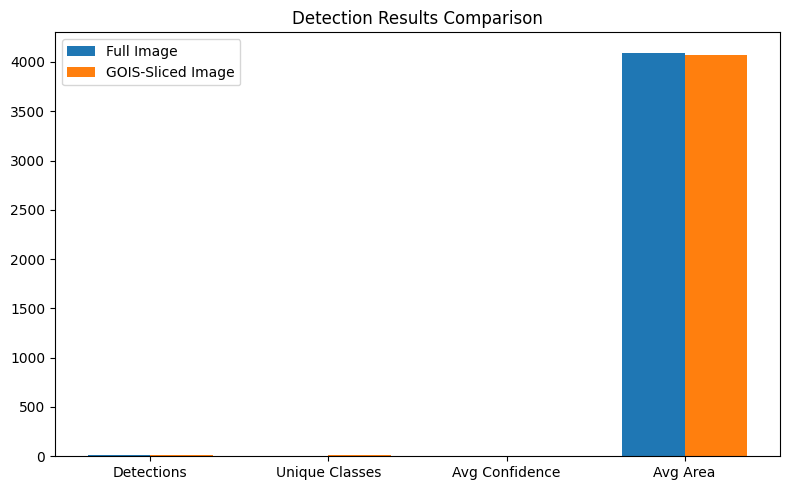

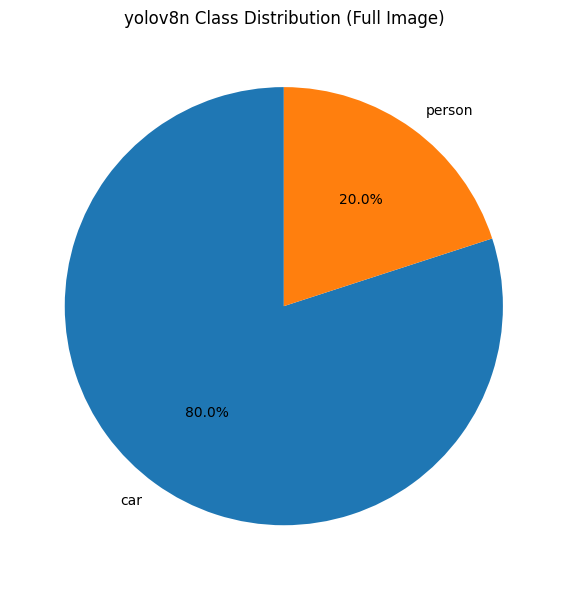

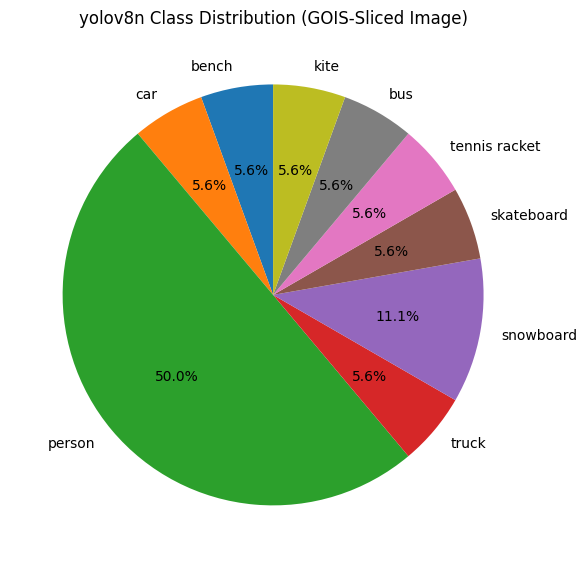

In [12]:
image_path = './single_test/images_v1/0000006_07596_d_0000020.jpg'
model_name = 'yolov8n'
confidence_threshold = 0.3
full_image_with_detections, gois_image_with_detections = predict(image_path, model_name, confidence_threshold)

In [10]:
len(full_image_with_detections), len(gois_image_with_detections)

NameError: name 'full_image_with_detections' is not defined


0: 384x640 2 persons, 8 cars, 21.6ms
Speed: 1.5ms preprocess, 21.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 640x640 (no detections), 30.8ms
Speed: 1.9ms preprocess, 30.8ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 bench, 32.7ms
Speed: 1.4ms preprocess, 32.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 30.1ms
Speed: 1.5ms preprocess, 30.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 30.0ms
Speed: 1.8ms preprocess, 30.0ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 41.9ms
Speed: 1.8ms preprocess, 41.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 30.2ms
Speed: 2.1ms preprocess, 30.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x352 (no detections), 22.4ms
Speed: 0.9ms preprocess, 22.4ms inference, 0.3ms 

In [8]:
# Gradio Interface
model_names = ["yolo11n", "yolov10n", "yolov9c", "yolov8n", "yolov5nu", "rtdetr-l", "yolov8s-worldv2", "yolov6-n"]

with gr.Blocks(css="""
        .gradio-container {
            background-color: #f5f5f5;
            font-family: Arial, sans-serif;
        }
""") as interface:
    gr.Markdown("# Object Detection using Full Image VS GOIS Framework Results")
    gr.Markdown("Upload an image and select a model to apply the Guided Object Inference Slicing (GOIS) technique.")

    with gr.Row():
        image_input = gr.Image(type="filepath", label="Upload an Image")
        model_dropdown = gr.Dropdown(choices=model_names, label="Select Model Name")
        confidence_slider = gr.Slider(minimum=0.0, maximum=1.0, value=0.25, step=0.05, label="Confidence Threshold")

    with gr.Tab("Detection Results"):
        with gr.Row():
            full_image_output = gr.Image(type="pil", label="Full Image Detection Result")
            gois_image_output = gr.Image(type="pil", label="GOIS-Sliced Image Detection Result")

    with gr.Tab("Metrics and Analysis"):
        metrics_table_output = gr.HTML(label="Detection Results Comparison")
        full_image_table = gr.HTML(label="Class Distribution (Full Image)")
        gois_image_table = gr.HTML(label="Class Distribution (Sliced Image)")

    with gr.Tab("Charts"):
        bar_chart_output = gr.Image(type="pil", label="Bar Chart - Full Image VS GOIS Detection Results Comparison")
        full_image_pie = gr.Image(type="pil", label="Full Image Class Distribution")
        gois_image_pie = gr.Image(type="pil", label="GOIS-Sliced Image Class Distribution")

    predict_button = gr.Button("Run Prediction")
    predict_button.click(fn=predict, inputs=[image_input, model_dropdown, confidence_slider], outputs=[
        full_image_output,
        gois_image_output,
        full_image_table,
        gois_image_table,
        bar_chart_output,
        full_image_pie,
        gois_image_pie,
        metrics_table_output
    ])

interface.launch(inline=True, share=True)

Running on local URL:  http://127.0.0.1:7861
Running on public URL: https://da3f06833706727847.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
